# Telco Churn Prediction with ML Pipeline

This notebook demonstrates an **end-to-end machine learning pipeline** for predicting customer churn using the **Telco Churn Dataset**.

### Objectives:
- Implement preprocessing (scaling, encoding) using `Pipeline`
- Train Logistic Regression and Random Forest models
- Use `GridSearchCV` for hyperparameter tuning
- Export the final pipeline using `joblib`

### Skills Gained:
- ML pipeline construction
- Hyperparameter tuning
- Model export & reusability
- Production readiness

## 1: Importing libraries 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

## 2. Load Dataset 

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Shape:", df.shape)
df.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Data Preprocessing

In [3]:
# Drop customerID (not useful for prediction)
df.drop("customerID", axis=1, inplace=True)


In [4]:
# Convert 'TotalCharges' to numeric (it has some missing/blank values)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

In [5]:
# Features & target
X = df.drop("Churn", axis=1)
y = df["Churn"].map({"Yes": 1, "No": 0})  # Convert target to 0/1

In [6]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Identify categorical & numerical features
cat_features = X.select_dtypes(include=["object"]).columns.tolist()
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [8]:
# Preprocessor: scaling numeric + encoding categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


## 4. Logistic Regression Pipeline

In [9]:
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

In [13]:
# Hyperparameter tuning with GridSearchCV
param_grid_lr = {
    "classifier__C": [0.1, 1, 10],
    "classifier__solver": ["liblinear", "lbfgs"]
}
grid_lr = GridSearchCV(log_reg, param_grid=param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1)
grid_lr.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['SeniorCitizen',
                                                                          'tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['gender',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

In [14]:
# Evaluate Logistic Regression
y_pred_lr = grid_lr.predict(X_test)
print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



## 5. Random Forest Pipeline

In [15]:
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [16]:
# Hyperparameter tuning with GridSearchCV
param_grid_rf = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [5, 10, None],
    "classifier__min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv=5, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['SeniorCitizen',
                                                                          'tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['gender',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10, None],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy')

In [17]:
# Evaluate Random Forest
y_pred_rf = grid_rf.predict(X_test)
print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



## 6. Visualizations

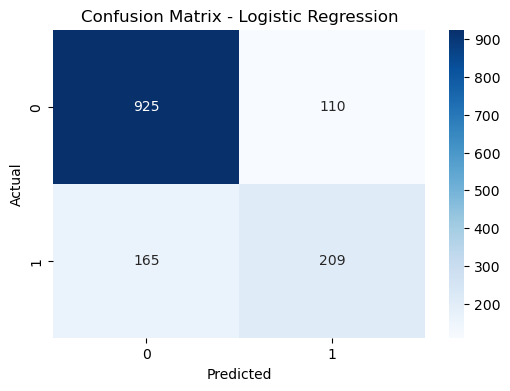

In [18]:
# Confusion Matrix for Logistic Regression
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

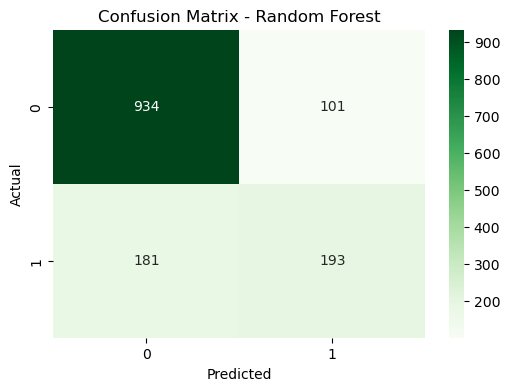

In [19]:
# Confusion Matrix for Random Forest
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


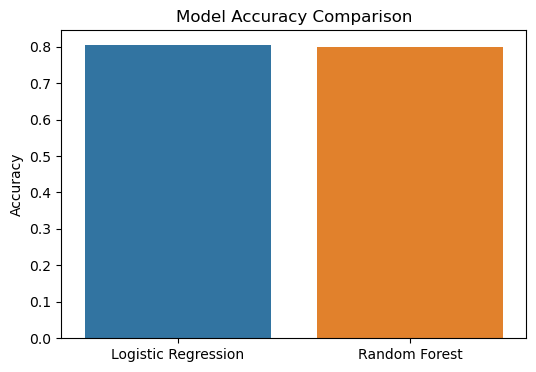

In [20]:
# Compare Accuracy
models = ["Logistic Regression", "Random Forest"]
accuracy = [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_rf)]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=accuracy)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

## 7. Export Pipelines

In [21]:
joblib.dump(grid_lr.best_estimator_, "logistic_regression_pipeline.pkl")
joblib.dump(grid_rf.best_estimator_, "random_forest_pipeline.pkl")

print("\nPipelines exported as logistic_regression_pipeline.pkl and random_forest_pipeline.pkl")


Pipelines exported as logistic_regression_pipeline.pkl and random_forest_pipeline.pkl
